# **Analyzing Amazon Reviews for the Health and Personal Care product category**

**Summary**:

Customer Satisfaction was derived from the ratings provided by customers alongside the review and was found to have very little correlation with the text and sentiment of the reviews provided by users.

This is why we switch to predicting whether the review would be helpful for the customers or not, based solely on the text. To that end, we use Count Vectorizer to create features out of the text and then use a Logistic Regression for binary classification of review - helpful or not. 

This approach was finalised after comparing Logistic Regression, Logistic Regression with GridSearch CV, SVM, & Random Forest. These 4 classification models were built for both Count Vectorizer & TF-IDF techniques used to featurize text.

We compare models on the basis of their recall - whether it was able to predict the review to be helpful correctly, reduce the number of False Negatives - reviews that were actually helpful were not caught by the model.
You may notice that Random Forest has marginally better recall in this case but we are selecting Logistic Regression for its simplicity and explainability.

In [2]:
#Load the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
#from textblob import TextBlob
#from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
import json
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopword_list = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
# data read

In [0]:
file_name = 'reviews_Health_and_Personal_Care_5.json'
records = []
with open(file_name, 'r') as f:
    for line in f:
        data = json.loads(line)
        records.append(data)
    f.close()
review = pd.DataFrame(records)
review = review.reset_index()


In [0]:
re_punc = re.compile('[%s]' % re.escape(string.punctuation))

def data_cleaning(text):
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()
    tokens = [re_punc.sub('', w) for w in text.split()]
    tokens = [token for token in tokens if token.isalpha()]
    tokens = [token for token in tokens if not token in stopword_list]
    tokens = [word for word in tokens if len(word) > 1]
    return tokens
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text])
    return text

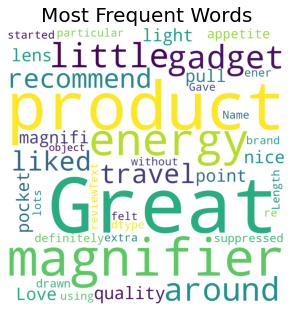

In [35]:

# word cloud
plt.rcParams['figure.figsize'] = (5, 50)
wordcloud = WordCloud(background_color = 'white', width = 1200,  height = 1200, max_words = 121).generate(str(review["reviewText"]))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Most Frequent Words',fontsize = 20)
plt.show()


In [0]:
# Defining the metric Customer Satisfaction - If customer's rating is 5 then they're satisfied, otherwise not.
# Since we're targeting unsatisfied customers - the target variable is defined accordingly.
review.loc[:, 'csat'] = np.where(review.loc[:, 'overall'] <= 4, 1, 0)

In [0]:
review['helpful_numerator'] = review['helpful'].apply(lambda x: x[0])
review['helpful_denominator'] = review['helpful'].apply(lambda x: x[1])


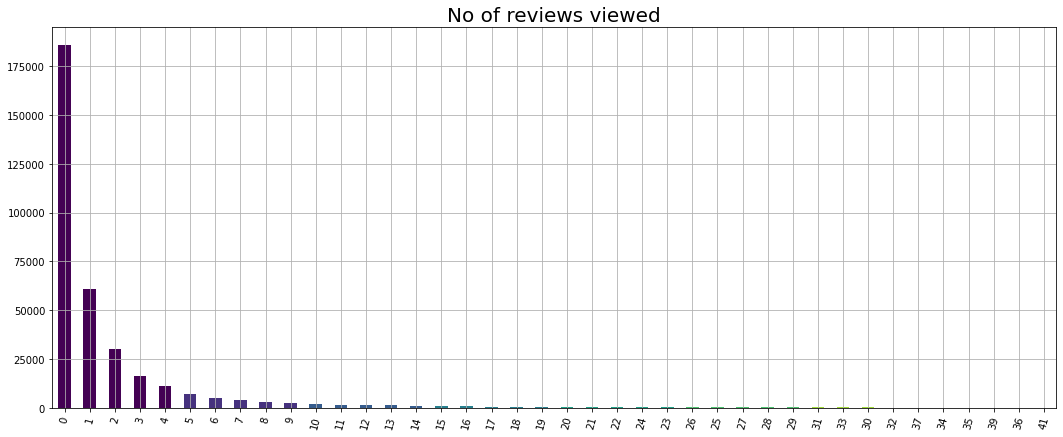

In [30]:
d1 = review[review['helpful_denominator']>0]
# reviews per item
viridis = plt.get_cmap('viridis', 8)
plt.rcParams['figure.figsize'] = (18, 7)
d1["helpful_denominator"].value_counts().head(40).plot.bar(color = viridis(np.linspace(0, 1, 40)))
plt.title('No of reviews viewed', fontsize = 20)
plt.xticks(rotation = 75 )
plt.grid()
plt.show()


# Review Helpfulness

In [0]:
reviews = review.sample(frac=0.5, replace=True, random_state=1)

In [12]:
reviews.head(5)

,index,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,helpful_numerator,helpful_denominator,Helpful
312201,312201,A3B0V4HRHE3ITR,B00BPBLMCS,W. Burton,"[10, 12]",thi doityourself shave set brilliant thought m...,5.0,Great Surprise,1369699200,"05 28, 2013",10,12,1
293372,293372,A1JCKIUEL3G1QZ,B008ZIVNDM,Susan Sparks,"[4, 7]",most product found work regardless result othe...,5.0,This Green Coffee is amazing it is REAL,1345420800,"08 20, 2012",4,7,0
51668,51668,A3KDH35C223VG5,B000G7YW74,R. Morel,"[10, 10]",thi devic littl piec plastic simpli get job do...,5.0,Very good product.,1190073600,"09 18, 2007",10,10,1
294103,294103,A3MWXF2CLXHBRI,B0093162SQ,"Catherine Jo Morgan ""abstract expressionist h...","[3, 7]",compar older philip wakeup light use halogen b...,3.0,Preliminary review: not as wonderful as it sounds,1350345600,"10 16, 2012",3,7,0
117565,117565,AA5ANBUMLM37V,B001AFD5P6,"Cheryl G. ""cgtravel""","[6, 6]",thi cane great mani posit comment bought cute ...,5.0,Love this cane!,1274572800,"05 23, 2010",6,6,1


In [0]:
# data cleaning

In [0]:
reviews["reviewText_1"] = reviews["reviewText"].apply(data_cleaning)

In [0]:
reviews["reviewText_1"] = reviews["reviewText_1"].apply(simple_stemmer)

In [0]:
reviews['helpful_numerator'] = reviews['helpful'].apply(lambda x: x[0])
reviews['helpful_denominator'] = reviews['helpful'].apply(lambda x: x[1])


In [0]:
threshold = 0.8

reviews.loc[:, 'Helpful'] = np.where(reviews.loc[:, 'helpful_numerator']/reviews.loc[:, 'helpful_denominator'] > threshold, 1, 0)

In [0]:
reviews = reviews.loc[reviews["helpful_denominator"]>5]

In [24]:
reviews["Helpful"].value_counts()

1    9720
0    7433
Name: Helpful, dtype: int64

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


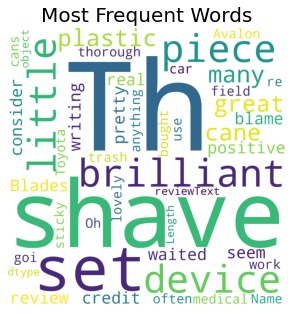

In [25]:
wc1 = reviews.loc[reviews["Helpful"]==1]
# word cloud
plt.rcParams['figure.figsize'] = (5, 50)
wordcloud = WordCloud(background_color = 'white', width = 1200,  height = 1200, max_words = 121).generate(str(wc1["reviewText"]))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Most Frequent Words',fontsize = 20)
plt.show()


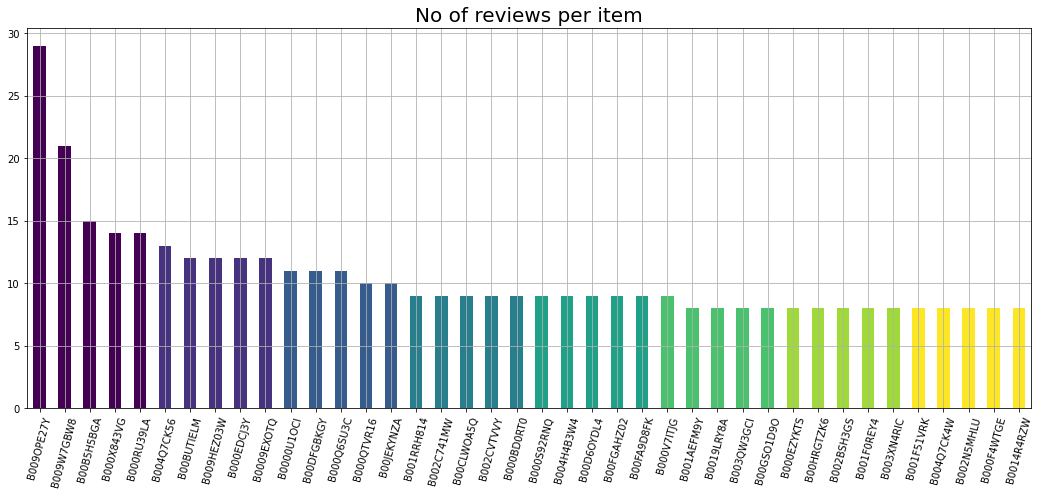

In [17]:

# reviews per item
viridis = plt.get_cmap('viridis', 8)
plt.rcParams['figure.figsize'] = (18, 7)
wc1["asin"].value_counts().head(40).plot.bar(color = viridis(np.linspace(0, 1, 40)))
plt.title('No of reviews per item', fontsize = 20)
plt.xticks(rotation = 75 )
plt.grid()
plt.show()


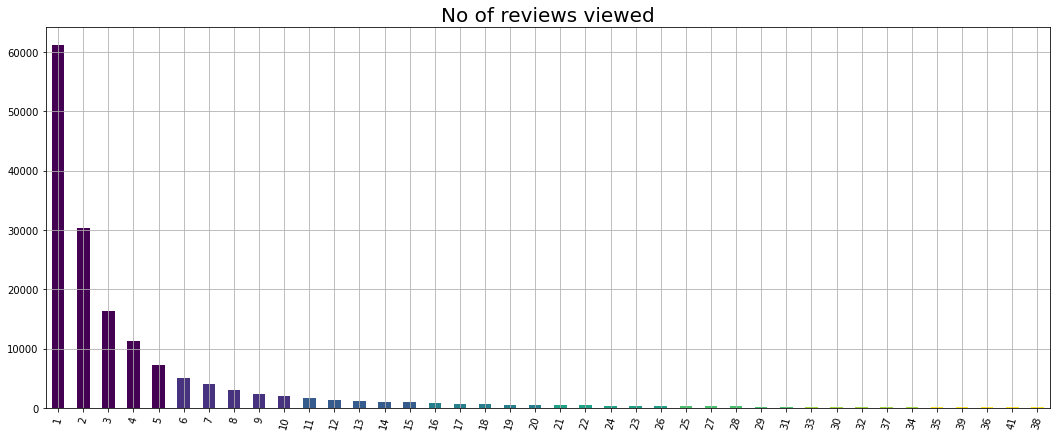

In [31]:
d1 = review[review["helpful_denominator"]>0]
# reviews per item
viridis = plt.get_cmap('viridis', 8)
plt.rcParams['figure.figsize'] = (18, 7)
d1["helpful_denominator"].value_counts().head(10).plot.bar(color = viridis(np.linspace(0, 1, 40)))
plt.title('No of people who viewed the review', fontsize = 20)
plt.xticks(rotation = 75 )
plt.grid()
plt.show()


## Count Vectorizer

In [0]:
X_train, X_test, y_train, y_test = train_test_split(reviews["reviewText_1"], reviews["Helpful"], train_size = 0.7)

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
#transformed train reviews
cv_train_reviews=cv.fit_transform(X_train)
#transformed test reviews
cv_test_reviews=cv.transform(X_test)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)



(12007,) (12007,)
(5146,) (5146,)
BOW_cv_train: (12007, 1079572)
BOW_cv_test: (5146, 1079572)
Tfidf_train: (12007, 1079572)
Tfidf_test: (5146, 1079572)


### Machine Learning Algorithms

In [0]:
# import ML libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import svm
from matplotlib.colors import ListedColormap
from sklearn.ensemble import RandomForestClassifier

#### Logistic Regression

In [0]:
logreg = LogisticRegression()

In [0]:
logreg.fit(cv_train_reviews, y_train)
y_train_pred = logreg.predict(cv_train_reviews)
y_test_pred = logreg.predict(cv_test_reviews)

In [0]:
pd.crosstab(y_test, y_test_pred, rownames=['Actual Result'], colnames=['Predicted Result'])

Predicted Result,0,1
Actual Result,,
0,615,1601
1,84,2846


In [0]:
print("Confusion Matrix:\n", metrics.confusion_matrix(y_test, y_test_pred))
print("Classification report:\n", metrics.classification_report(y_test, y_test_pred))
print("Accuracy:\t", metrics.accuracy_score(y_test, y_test_pred))
print("Precision:\t", metrics.precision_score(y_test, y_test_pred))
print("Recall:   \t", metrics.recall_score(y_test, y_test_pred))
print("ROC AUC score:\t", metrics.roc_auc_score(y_test, y_test_pred))

Confusion Matrix:
 [[ 615 1601]
 [  84 2846]]
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.28      0.42      2216
           1       0.64      0.97      0.77      2930

    accuracy                           0.67      5146
   macro avg       0.76      0.62      0.60      5146
weighted avg       0.74      0.67      0.62      5146

Accuracy:	 0.6725612125923047
Precision:	 0.6399820103440522
Recall:   	 0.9713310580204778
ROC AUC score:	 0.6244290669163761


#### Logistic Regression - CV

In [0]:
penalty = ['l2']
C = np.logspace(-4, 4, 10)
hyperparameters = dict(C=C, penalty=penalty)

logreg_gridsearchCV = GridSearchCV(LogisticRegression(solver = 'lbfgs'), hyperparameters, cv=5, verbose=0)

logreg_gridsearchCV.fit(cv_train_reviews, y_train)

print('Best Penalty:', logreg_gridsearchCV.best_estimator_.get_params()['penalty'])
print('Best C:', logreg_gridsearchCV.best_estimator_.get_params()['C'])

Best Penalty: l2
Best C: 0.0001


In [0]:
y_test_pred = logreg_gridsearchCV.predict(cv_test_reviews)
pd.crosstab(y_test, y_test_pred, rownames=['Actual Result'], colnames=['Predicted Result'])

Predicted Result,1
Actual Result,
0,2216
1,2930


In [0]:
print("Confusion Matrix:\n", metrics.confusion_matrix(y_test, y_test_pred))
print("Classification report:\n", metrics.classification_report(y_test, y_test_pred))
print("Accuracy:\t", metrics.accuracy_score(y_test, y_test_pred))
print("Precision:\t", metrics.precision_score(y_test, y_test_pred))
print("Recall:   \t", metrics.recall_score(y_test, y_test_pred))
print("ROC AUC score:\t", metrics.roc_auc_score(y_test, y_test_pred))

Confusion Matrix:
 [[   0 2216]
 [   0 2930]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      2216
           1       0.57      1.00      0.73      2930

    accuracy                           0.57      5146
   macro avg       0.28      0.50      0.36      5146
weighted avg       0.32      0.57      0.41      5146

Accuracy:	 0.569374271278663
Precision:	 0.569374271278663
Recall:   	 1.0
ROC AUC score:	 0.5


#### Support Vector Machine

Linear Kernel

In [0]:
svm_lin = svm.SVC(kernel = "linear")

In [0]:
svm_lin.fit(cv_train_reviews, y_train)
y_test_pred = svm_lin.predict(cv_test_reviews)

In [0]:
pd.crosstab(y_test, y_test_pred, rownames=['Actual Result'], colnames=['Predicted Result'])

Predicted Result,0,1
Actual Result,,
0,528,1688
1,8,2922


In [0]:
print("Confusion Matrix:\n", metrics.confusion_matrix(y_test, y_test_pred))
print("Classification report:\n", metrics.classification_report(y_test, y_test_pred))
print("Accuracy:\t", metrics.accuracy_score(y_test, y_test_pred))
print("Precision:\t", metrics.precision_score(y_test, y_test_pred))
print("Recall:   \t", metrics.recall_score(y_test, y_test_pred))
print("ROC AUC score:\t", metrics.roc_auc_score(y_test, y_test_pred))

Confusion Matrix:
 [[ 528 1688]
 [   8 2922]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      0.24      0.38      2216
           1       0.63      1.00      0.78      2930

    accuracy                           0.67      5146
   macro avg       0.81      0.62      0.58      5146
weighted avg       0.79      0.67      0.61      5146

Accuracy:	 0.6704236300038865
Precision:	 0.6338394793926247
Recall:   	 0.9972696245733789
ROC AUC score:	 0.6177683862939096


#### Random Forest Classification

In [0]:
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)

In [0]:
rf.fit(cv_train_reviews, y_train)
y_test_pred = rf.predict(cv_test_reviews)
rf.score(cv_test_reviews, y_test)

0.6682860474154684

In [0]:
pd.crosstab(y_test, y_test_pred, rownames=['Actual Result'], colnames=['Predicted Result'])

Predicted Result,0,1
Actual Result,,
0,552,1664
1,43,2887


In [0]:
print("Confusion Matrix:\n", metrics.confusion_matrix(y_test, y_test_pred))
print("Classification report:\n", metrics.classification_report(y_test, y_test_pred))
print("Accuracy:\t", metrics.accuracy_score(y_test, y_test_pred))
print("Precision:\t", metrics.precision_score(y_test, y_test_pred))
print("Recall:   \t", metrics.recall_score(y_test, y_test_pred))
print("ROC AUC score:\t", metrics.roc_auc_score(y_test, y_test_pred))

Confusion Matrix:
 [[ 552 1664]
 [  43 2887]]
Classification report:
               precision    recall  f1-score   support

           0       0.93      0.25      0.39      2216
           1       0.63      0.99      0.77      2930

    accuracy                           0.67      5146
   macro avg       0.78      0.62      0.58      5146
weighted avg       0.76      0.67      0.61      5146

Accuracy:	 0.6682860474154684
Precision:	 0.6343660733904636
Recall:   	 0.9853242320819112
ROC AUC score:	 0.6172108525030495


## TF_IDF Vectorizer

In [0]:
X_train, X_test, y_train, y_test = train_test_split(reviews["reviewText_1"], reviews["Helpful"], train_size = 0.7)

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
#transformed train reviews
tv_train_reviews=tv.fit_transform(X_train)
#transformed test reviews
tv_test_reviews=tv.transform(X_test)
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

(12007,) (12007,)
(5146,) (5146,)
Tfidf_train: (12007, 1072435)
Tfidf_test: (5146, 1072435)


### Machine Learning Algorithms

In [0]:
# import ML libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import svm
from matplotlib.colors import ListedColormap
from sklearn.ensemble import RandomForestClassifier

#### Logistic Regression

In [0]:
logreg = LogisticRegression()

In [0]:
logreg.fit(tv_train_reviews, y_train)
y_train_pred = logreg.predict(tv_train_reviews)
y_test_pred = logreg.predict(tv_test_reviews)

In [0]:
pd.crosstab(y_train, y_train_pred, rownames=['Actual Result'], colnames=['Predicted Result'])

Predicted Result,0,1
Actual Result,,
0,3714,1546
1,0,6747


In [0]:
pd.crosstab(y_test, y_test_pred, rownames=['Actual Result'], colnames=['Predicted Result'])

Predicted Result,0,1
Actual Result,,
0,509,1664
1,0,2973


In [0]:
print("Confusion Matrix:\n", metrics.confusion_matrix(y_test, y_test_pred))
print("Classification report:\n", metrics.classification_report(y_test, y_test_pred))
print("Accuracy:\t", metrics.accuracy_score(y_test, y_test_pred))
print("Precision:\t", metrics.precision_score(y_test, y_test_pred))
print("Recall:   \t", metrics.recall_score(y_test, y_test_pred))
print("ROC AUC score:\t", metrics.roc_auc_score(y_test, y_test_pred))

Confusion Matrix:
 [[ 509 1664]
 [   0 2973]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.23      0.38      2173
           1       0.64      1.00      0.78      2973

    accuracy                           0.68      5146
   macro avg       0.82      0.62      0.58      5146
weighted avg       0.79      0.68      0.61      5146

Accuracy:	 0.6766420520792849
Precision:	 0.6411472935087341
Recall:   	 1.0
ROC AUC score:	 0.6171191900598252


In [0]:
print("Confusion Matrix:\n", metrics.confusion_matrix(y_train, y_train_pred))
print("Classification report:\n", metrics.classification_report(y_train, y_train_pred))
print("Accuracy:\t", metrics.accuracy_score(y_train, y_train_pred))
print("Precision:\t", metrics.precision_score(y_train, y_train_pred))
print("Recall:   \t", metrics.recall_score(y_train, y_train_pred))
print("ROC AUC score:\t", metrics.roc_auc_score(y_train, y_train_pred))

Confusion Matrix:
 [[3714 1546]
 [   0 6747]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.71      0.83      5260
           1       0.81      1.00      0.90      6747

    accuracy                           0.87     12007
   macro avg       0.91      0.85      0.86     12007
weighted avg       0.90      0.87      0.87     12007

Accuracy:	 0.871241775630882
Precision:	 0.8135777161461474
Recall:   	 1.0
ROC AUC score:	 0.853041825095057


#### Logistic Regression - CV

In [0]:
penalty = ['l2']
C = np.logspace(-4, 4, 10)
hyperparameters = dict(C=C, penalty=penalty)

logreg_gridsearchCV = GridSearchCV(LogisticRegression(solver = 'lbfgs'), hyperparameters, cv=5, verbose=0)

logreg_gridsearchCV.fit(tv_train_reviews, y_train)

print('Best Penalty:', logreg_gridsearchCV.best_estimator_.get_params()['penalty'])
print('Best C:', logreg_gridsearchCV.best_estimator_.get_params()['C'])

Best Penalty: l2
Best C: 0.0001


In [0]:
y_test_pred = logreg_gridsearchCV.predict(tv_test_reviews)
pd.crosstab(y_test, y_test_pred, rownames=['Actual Result'], colnames=['Predicted Result'])

Predicted Result,1
Actual Result,
0,2173
1,2973


In [0]:
print("Confusion Matrix:\n", metrics.confusion_matrix(y_test, y_test_pred))
print("Classification report:\n", metrics.classification_report(y_test, y_test_pred))
print("Accuracy:\t", metrics.accuracy_score(y_test, y_test_pred))
print("Precision:\t", metrics.precision_score(y_test, y_test_pred))
print("Recall:   \t", metrics.recall_score(y_test, y_test_pred))
print("ROC AUC score:\t", metrics.roc_auc_score(y_test, y_test_pred))

Confusion Matrix:
 [[   0 2173]
 [   0 2973]]
Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      2173
           1       0.58      1.00      0.73      2973

    accuracy                           0.58      5146
   macro avg       0.29      0.50      0.37      5146
weighted avg       0.33      0.58      0.42      5146

Accuracy:	 0.5777302759424796
Precision:	 0.5777302759424796
Recall:   	 1.0
ROC AUC score:	 0.5


#### Support Vector Machine

Linear Kernel

In [0]:
svm_lin = svm.SVC(kernel = "linear")

In [0]:
svm_lin.fit(tv_train_reviews, y_train)
y_test_pred = svm_lin.predict(tv_test_reviews)

In [0]:
pd.crosstab(y_test, y_test_pred, rownames=['Actual Result'], colnames=['Predicted Result'])

Predicted Result,0,1
Actual Result,,
0,517,1656
1,5,2968


In [0]:
print("Confusion Matrix:\n", metrics.confusion_matrix(y_test, y_test_pred))
print("Classification report:\n", metrics.classification_report(y_test, y_test_pred))
print("Accuracy:\t", metrics.accuracy_score(y_test, y_test_pred))
print("Precision:\t", metrics.precision_score(y_test, y_test_pred))
print("Recall:   \t", metrics.recall_score(y_test, y_test_pred))
print("ROC AUC score:\t", metrics.roc_auc_score(y_test, y_test_pred))

Confusion Matrix:
 [[ 517 1656]
 [   5 2968]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      0.24      0.38      2173
           1       0.64      1.00      0.78      2973

    accuracy                           0.68      5146
   macro avg       0.82      0.62      0.58      5146
weighted avg       0.79      0.68      0.61      5146

Accuracy:	 0.6772250291488535
Precision:	 0.6418685121107266
Recall:   	 0.9983181971072991
ROC AUC score:	 0.6181190617381871


#### Random Forest Classification

In [0]:
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)

In [0]:
rf.fit(tv_train_reviews, y_train)
y_test_pred = rf.predict(tv_test_reviews)
rf.score(tv_test_reviews, y_test)

0.6791682860474154

In [0]:
pd.crosstab(y_test, y_test_pred, rownames=['Actual Result'], colnames=['Predicted Result'])

Predicted Result,0,1
Actual Result,,
0,537,1636
1,15,2958


In [0]:
print("Confusion Matrix:\n", metrics.confusion_matrix(y_test, y_test_pred))
print("Classification report:\n", metrics.classification_report(y_test, y_test_pred))
print("Accuracy:\t", metrics.accuracy_score(y_test, y_test_pred))
print("Precision:\t", metrics.precision_score(y_test, y_test_pred))
print("Recall:   \t", metrics.recall_score(y_test, y_test_pred))
print("ROC AUC score:\t", metrics.roc_auc_score(y_test, y_test_pred))

Confusion Matrix:
 [[ 537 1636]
 [  15 2958]]
Classification report:
               precision    recall  f1-score   support

           0       0.97      0.25      0.39      2173
           1       0.64      0.99      0.78      2973

    accuracy                           0.68      5146
   macro avg       0.81      0.62      0.59      5146
weighted avg       0.78      0.68      0.62      5146

Accuracy:	 0.6791682860474154
Precision:	 0.6438833260774924
Recall:   	 0.9949545913218971
ROC AUC score:	 0.6210391916572671


# Customer Satisfaction

In [0]:
reviews_csat = review.sample(frac=0.08, replace=True, random_state=1)

In [40]:
reviews_csat.head(5)

,index,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
128037,128037,A36CCLPMU6YDYL,B001EPQ9IM,"E. Heppert ""Beth""","[0, 0]",My husband was having trouble with his stinky ...,5.0,They work!,1357084800,"01 2, 2013"
267336,267336,A3M4GPZ5MMSSWU,B006T6XCP4,plazaliz,"[0, 0]",Great fragrance. Diminished facial scar signif...,5.0,Wonderfully Versatile Oil,1373068800,"07 6, 2013"
312201,312201,A3B0V4HRHE3ITR,B00BPBLMCS,W. Burton,"[10, 12]",This Do-It-Yourself shave set is brilliant. Th...,5.0,Great Surprise,1369699200,"05 28, 2013"
73349,73349,A1XIRB17MOLXPB,B000O58QM0,Judith Treidler,"[0, 0]",Would purchase again if necessary. Very good i...,5.0,Works as advertised,1360713600,"02 13, 2013"
117583,117583,A1XQ0F01CF84Y3,B001AFDAU6,Caligal,"[0, 0]",Very good support while driving or in office c...,5.0,Great,1361750400,"02 25, 2013"


In [41]:
reviews_csat.groupby(["overall"]).count()

,index,reviewerID,asin,reviewerName,helpful,reviewText,summary,unixReviewTime,reviewTime
overall,,,,,,,,,
1.0,1666,1666,1666,1648,1666,1666,1666,1666,1666
2.0,1634,1634,1634,1621,1634,1634,1634,1634,1634
3.0,3359,3359,3359,3334,3359,3359,3359,3359,3359
4.0,6830,6830,6830,6788,6830,6830,6830,6830,6830
5.0,21147,21147,21147,20956,21147,21147,21147,21147,21147


In [0]:
# data cleaning

In [0]:
reviews_csat["reviewText_1"] = reviews_csat["reviewText"].apply(data_cleaning)

In [0]:
reviews_csat["reviewText_1"] = reviews_csat["reviewText_1"].apply(simple_stemmer)

In [0]:
reviews_csat.loc[:, 'csat'] = np.where(reviews_csat.loc[:, 'overall'] <= 4, 1, 0)

In [0]:
reviews_csat.head(20)

In [46]:
reviews_csat["csat"].value_counts()

0    21147
1    13489
Name: csat, dtype: int64

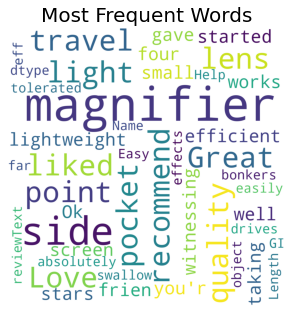

In [61]:
wc2 = review.loc[review["csat"]==1]
# word cloud
plt.rcParams['figure.figsize'] = (5, 50)
wordcloud = WordCloud(background_color = 'white', width = 1200,  height = 1200, max_words = 121).generate(str(wc2["reviewText"]))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Most Frequent Words',fontsize = 20)
plt.show()


## Count Vectorizer

In [66]:
X_train, X_test, y_train, y_test = train_test_split(reviews_csat["reviewText_1"], reviews_csat["csat"], train_size = 0.7)

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
#transformed train reviews
cv_train_reviews=cv.fit_transform(X_train)
#transformed test reviews
cv_test_reviews=cv.transform(X_test)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)



(19395,) (19395,)
(8313,) (8313,)
BOW_cv_train: (19395, 1185785)
BOW_cv_test: (8313, 1185785)


### Machine Learning Algorithms

In [0]:
# import ML libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import svm
from matplotlib.colors import ListedColormap
from sklearn.ensemble import RandomForestClassifier

#### Logistic Regression

In [0]:
logreg = LogisticRegression()

In [0]:
logreg.fit(cv_train_reviews, y_train)
y_train_pred = logreg.predict(cv_train_reviews)
y_test_pred = logreg.predict(cv_test_reviews)

In [69]:
pd.crosstab(y_test, y_test_pred, rownames=['Actual Result'], colnames=['Predicted Result'])

Predicted Result,0,1
Actual Result,,
0,5063,5
1,3080,165


In [70]:
print("Confusion Matrix:\n", metrics.confusion_matrix(y_test, y_test_pred))
print("Classification report:\n", metrics.classification_report(y_test, y_test_pred))
print("Accuracy:\t", metrics.accuracy_score(y_test, y_test_pred))
print("Precision:\t", metrics.precision_score(y_test, y_test_pred))
print("Recall:   \t", metrics.recall_score(y_test, y_test_pred))
print("ROC AUC score:\t", metrics.roc_auc_score(y_test, y_test_pred))

Confusion Matrix:
 [[5063    5]
 [3080  165]]
Classification report:
               precision    recall  f1-score   support

           0       0.62      1.00      0.77      5068
           1       0.97      0.05      0.10      3245

    accuracy                           0.63      8313
   macro avg       0.80      0.52      0.43      8313
weighted avg       0.76      0.63      0.51      8313

Accuracy:	 0.6288945025863106
Precision:	 0.9705882352941176
Recall:   	 0.05084745762711865
ROC AUC score:	 0.5249304375744117


#### Logistic Regression - CV

In [71]:
penalty = ['l2']
C = np.logspace(-4, 4, 10)
hyperparameters = dict(C=C, penalty=penalty)

logreg_gridsearchCV = GridSearchCV(LogisticRegression(solver = 'lbfgs'), hyperparameters, cv=5, verbose=0)

logreg_gridsearchCV.fit(cv_train_reviews, y_train)

print('Best Penalty:', logreg_gridsearchCV.best_estimator_.get_params()['penalty'])
print('Best C:', logreg_gridsearchCV.best_estimator_.get_params()['C'])

Best Penalty: l2
Best C: 0.0001


In [72]:
y_test_pred = logreg_gridsearchCV.predict(cv_test_reviews)
pd.crosstab(y_test, y_test_pred, rownames=['Actual Result'], colnames=['Predicted Result'])

Predicted Result,0
Actual Result,
0,5068
1,3245


In [73]:
print("Confusion Matrix:\n", metrics.confusion_matrix(y_test, y_test_pred))
print("Classification report:\n", metrics.classification_report(y_test, y_test_pred))
print("Accuracy:\t", metrics.accuracy_score(y_test, y_test_pred))
print("Precision:\t", metrics.precision_score(y_test, y_test_pred))
print("Recall:   \t", metrics.recall_score(y_test, y_test_pred))
print("ROC AUC score:\t", metrics.roc_auc_score(y_test, y_test_pred))

Confusion Matrix:
 [[5068    0]
 [3245    0]]
Classification report:
               precision    recall  f1-score   support

           0       0.61      1.00      0.76      5068
           1       0.00      0.00      0.00      3245

    accuracy                           0.61      8313
   macro avg       0.30      0.50      0.38      8313
weighted avg       0.37      0.61      0.46      8313

Accuracy:	 0.6096475399975941
Precision:	 0.0
Recall:   	 0.0
ROC AUC score:	 0.5


#### Support Vector Machine

Linear Kernel

In [0]:
svm_lin = svm.SVC(kernel = "linear")

In [0]:
svm_lin.fit(cv_train_reviews, y_train)
y_test_pred = svm_lin.predict(cv_test_reviews)

In [76]:
pd.crosstab(y_test, y_test_pred, rownames=['Actual Result'], colnames=['Predicted Result'])

Predicted Result,0,1
Actual Result,,
0,5059,9
1,3081,164


In [77]:
print("Confusion Matrix:\n", metrics.confusion_matrix(y_test, y_test_pred))
print("Classification report:\n", metrics.classification_report(y_test, y_test_pred))
print("Accuracy:\t", metrics.accuracy_score(y_test, y_test_pred))
print("Precision:\t", metrics.precision_score(y_test, y_test_pred))
print("Recall:   \t", metrics.recall_score(y_test, y_test_pred))
print("ROC AUC score:\t", metrics.roc_auc_score(y_test, y_test_pred))

Confusion Matrix:
 [[5059    9]
 [3081  164]]
Classification report:
               precision    recall  f1-score   support

           0       0.62      1.00      0.77      5068
           1       0.95      0.05      0.10      3245

    accuracy                           0.63      8313
   macro avg       0.78      0.52      0.43      8313
weighted avg       0.75      0.63      0.50      8313

Accuracy:	 0.6282930350054132
Precision:	 0.9479768786127167
Recall:   	 0.050539291217257316
ROC AUC score:	 0.524381721378163


#### Random Forest Classification

In [0]:
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)

In [0]:
rf.fit(cv_train_reviews, y_train)
y_test_pred = rf.predict(cv_test_reviews)
rf.score(cv_test_reviews, y_test)

In [0]:
pd.crosstab(y_test, y_test_pred, rownames=['Actual Result'], colnames=['Predicted Result'])

In [0]:
print("Confusion Matrix:\n", metrics.confusion_matrix(y_test, y_test_pred))
print("Classification report:\n", metrics.classification_report(y_test, y_test_pred))
print("Accuracy:\t", metrics.accuracy_score(y_test, y_test_pred))
print("Precision:\t", metrics.precision_score(y_test, y_test_pred))
print("Recall:   \t", metrics.recall_score(y_test, y_test_pred))
print("ROC AUC score:\t", metrics.roc_auc_score(y_test, y_test_pred))

## TF_IDF Vectorizer

In [0]:
X_train, X_test, y_train, y_test = train_test_split(reviews_csat["reviewText_1"], reviews_csat["csat"], train_size = 0.7)

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
#transformed train reviews
tv_train_reviews=tv.fit_transform(X_train)
#transformed test reviews
tv_test_reviews=tv.transform(X_test)
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

### Machine Learning Algorithms

In [0]:
# import ML libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import svm
from matplotlib.colors import ListedColormap
from sklearn.ensemble import RandomForestClassifier

#### Logistic Regression

In [0]:
logreg = LogisticRegression()

In [0]:
logreg.fit(tv_train_reviews, y_train)
y_train_pred = logreg.predict(tv_train_reviews)
y_test_pred = logreg.predict(tv_test_reviews)

In [0]:
pd.crosstab(y_train, y_train_pred, rownames=['Actual Result'], colnames=['Predicted Result'])

In [0]:
pd.crosstab(y_test, y_test_pred, rownames=['Actual Result'], colnames=['Predicted Result'])

In [0]:
print("Confusion Matrix:\n", metrics.confusion_matrix(y_test, y_test_pred))
print("Classification report:\n", metrics.classification_report(y_test, y_test_pred))
print("Accuracy:\t", metrics.accuracy_score(y_test, y_test_pred))
print("Precision:\t", metrics.precision_score(y_test, y_test_pred))
print("Recall:   \t", metrics.recall_score(y_test, y_test_pred))
print("ROC AUC score:\t", metrics.roc_auc_score(y_test, y_test_pred))

In [0]:
print("Confusion Matrix:\n", metrics.confusion_matrix(y_train, y_train_pred))
print("Classification report:\n", metrics.classification_report(y_train, y_train_pred))
print("Accuracy:\t", metrics.accuracy_score(y_train, y_train_pred))
print("Precision:\t", metrics.precision_score(y_train, y_train_pred))
print("Recall:   \t", metrics.recall_score(y_train, y_train_pred))
print("ROC AUC score:\t", metrics.roc_auc_score(y_train, y_train_pred))

#### Logistic Regression - CV

In [0]:
penalty = ['l2']
C = np.logspace(-4, 4, 10)
hyperparameters = dict(C=C, penalty=penalty)

logreg_gridsearchCV = GridSearchCV(LogisticRegression(solver = 'lbfgs'), hyperparameters, cv=5, verbose=0)

logreg_gridsearchCV.fit(tv_train_reviews, y_train)

print('Best Penalty:', logreg_gridsearchCV.best_estimator_.get_params()['penalty'])
print('Best C:', logreg_gridsearchCV.best_estimator_.get_params()['C'])

In [0]:
y_test_pred = logreg_gridsearchCV.predict(tv_test_reviews)
pd.crosstab(y_test, y_test_pred, rownames=['Actual Result'], colnames=['Predicted Result'])

In [0]:
print("Confusion Matrix:\n", metrics.confusion_matrix(y_test, y_test_pred))
print("Classification report:\n", metrics.classification_report(y_test, y_test_pred))
print("Accuracy:\t", metrics.accuracy_score(y_test, y_test_pred))
print("Precision:\t", metrics.precision_score(y_test, y_test_pred))
print("Recall:   \t", metrics.recall_score(y_test, y_test_pred))
print("ROC AUC score:\t", metrics.roc_auc_score(y_test, y_test_pred))

#### Support Vector Machine

Linear Kernel

In [0]:
svm_lin = svm.SVC(kernel = "linear")

In [0]:
svm_lin.fit(tv_train_reviews, y_train)
y_test_pred = svm_lin.predict(tv_test_reviews)

In [0]:
pd.crosstab(y_test, y_test_pred, rownames=['Actual Result'], colnames=['Predicted Result'])

In [0]:
print("Confusion Matrix:\n", metrics.confusion_matrix(y_test, y_test_pred))
print("Classification report:\n", metrics.classification_report(y_test, y_test_pred))
print("Accuracy:\t", metrics.accuracy_score(y_test, y_test_pred))
print("Precision:\t", metrics.precision_score(y_test, y_test_pred))
print("Recall:   \t", metrics.recall_score(y_test, y_test_pred))
print("ROC AUC score:\t", metrics.roc_auc_score(y_test, y_test_pred))

#### Random Forest Classification

In [0]:
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)

In [0]:
rf.fit(tv_train_reviews, y_train)
y_test_pred = rf.predict(tv_test_reviews)
rf.score(tv_test_reviews, y_test)

In [0]:
pd.crosstab(y_test, y_test_pred, rownames=['Actual Result'], colnames=['Predicted Result'])

In [0]:
print("Confusion Matrix:\n", metrics.confusion_matrix(y_test, y_test_pred))
print("Classification report:\n", metrics.classification_report(y_test, y_test_pred))
print("Accuracy:\t", metrics.accuracy_score(y_test, y_test_pred))
print("Precision:\t", metrics.precision_score(y_test, y_test_pred))
print("Recall:   \t", metrics.recall_score(y_test, y_test_pred))
print("ROC AUC score:\t", metrics.roc_auc_score(y_test, y_test_pred))